In [1]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_full.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

X = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

X = X.to_numpy()
X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
print(K.shape, type(K))

t_max = 20
step = 0.001

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

print("NaNs in cog:", np.isnan(cog).sum())
print("Infs in cog:", np.isinf(cog).sum())

original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
X.size:  (504, 68) X_resid.size:  (504, 68)
NaNs in cog: 0
Infs in cog: 0


In [3]:
def plot_cog_regression_history(cog_history: np.ndarray):
    n_params, num_iterations = cog_history.shape
    
    # cog_error = np.zeros_like(cog_history)
    # for i in range(num_iterations):
    #     cog_error[:,i] = cog_error[:,i] - cog_true
    
    plt.figure(figsize=(10, 5))
    for i in range(n_params):
        label = f"a_{i}" if i < n_params - 1 else "b"
        plt.plot(range(num_iterations), cog_history[i,:], label=label)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("estimated coefficient value")
    plt.title("cog_parameters")
    plt.grid(True)
    plt.show()

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

100%|██████████| 20/20 [1:20:09<00:00, 240.45s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.2        0.2        0.14854276 0.2        0.2        0.2
 0.1852404  0.16085769 0.2        0.1731264 ]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac.npz
initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  1.3175898758309974
final theta:
f:  [0.2   0.2   0.149 0.2   0.2   0.2   0.185 0.161 0.2   0.173]
s:  [2.45  2.401 2.518 1.995 3.239 2.753 2.387 2.688 2.242 2.223]
s_k:  0.9345262931739303

BETA SUMMARY:
beta initial:  [ 5.054  9.18   3.812  3.025 19.085 12.867  3.925  4.536  1.359 11.14 ]
beta final:  [14.68  12.38  14.479 20.     9.746 12.595 11.334 13.154 13.923 10.958]


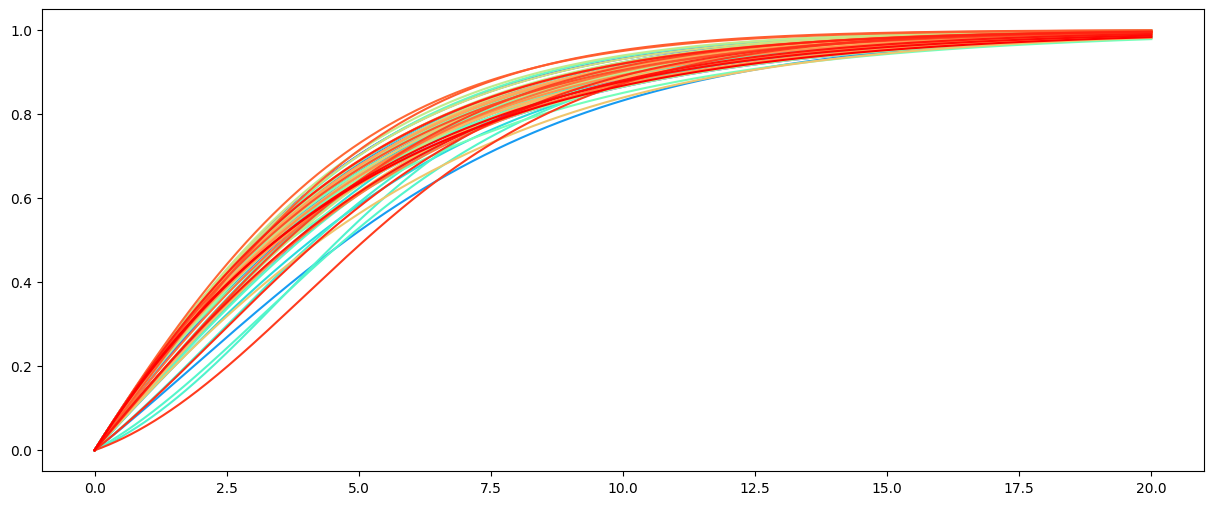

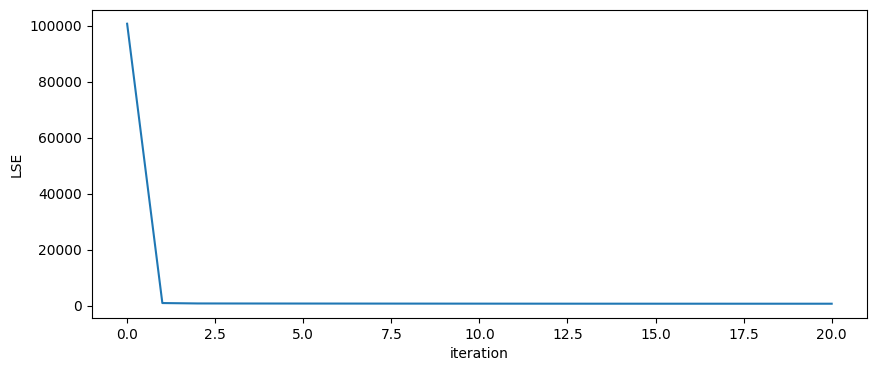

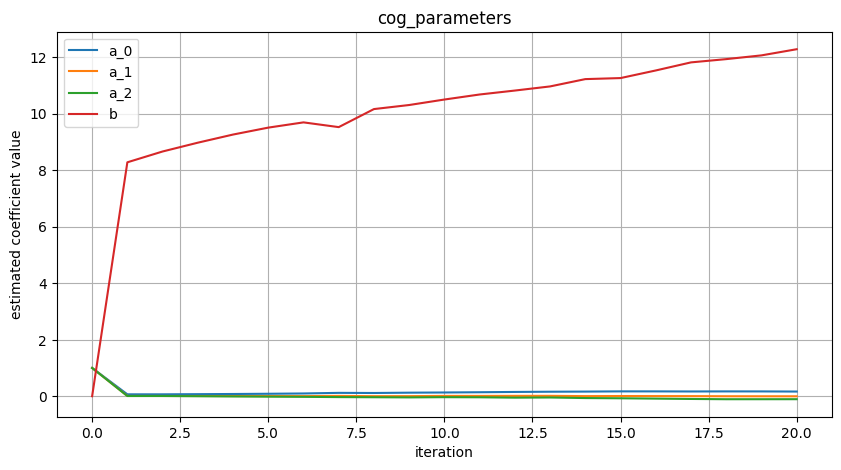

In [4]:
em_model_0 = EM(num_iterations=20, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.0)

path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac"
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K,
               save_path=path)
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

plot_lse(lse_history)
plot_cog_regression_history(em_model_0.cog_regression_history)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

100%|██████████| 20/20 [46:32<00:00, 139.64s/it] 



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.17644256 0.11930378 0.15577272 0.06006801 0.         0.0617368
 0.19022141 0.19455864 0.18763827 0.19384677]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac_lc001.npz
initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  1.3175898758309974
final theta:
f:  [0.176 0.119 0.156 0.06  0.    0.062 0.19  0.195 0.188 0.194]
s:  [2.386 2.336 2.437 2.738 3.205 3.401 2.323 2.639 2.205 2.156]
s_k:  4.9251371960228365

BETA SUMMARY:
beta initial:  [ 5.054  9.18   3.812  3.025 19.085 12.867  3.925  4.536  1.359 11.14 ]
beta final:  [19.891 19.272 19.51  20.    16.038 19.474 18.083 19.141 20.    18.077]


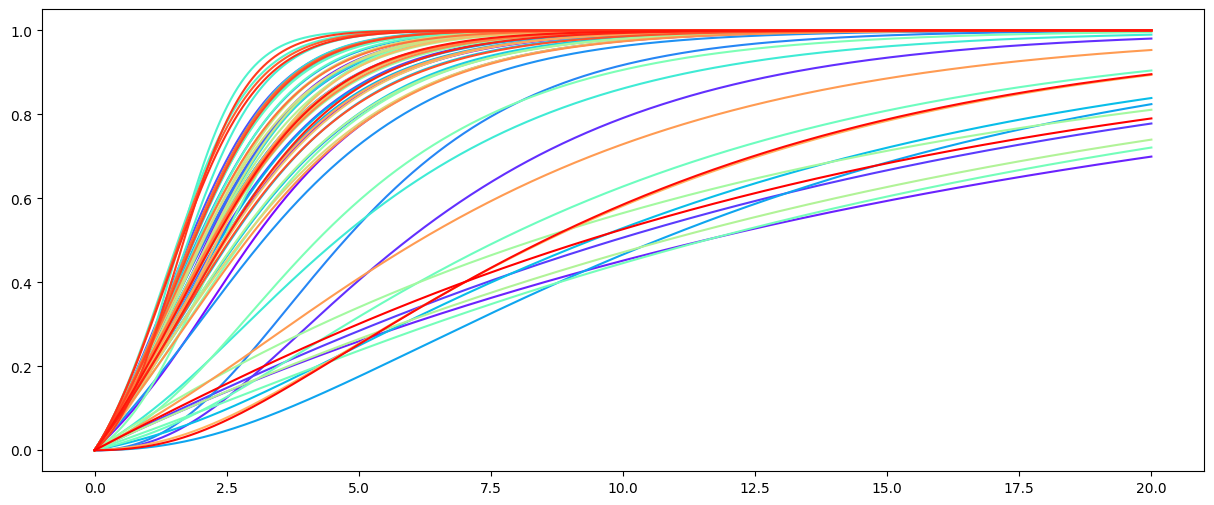

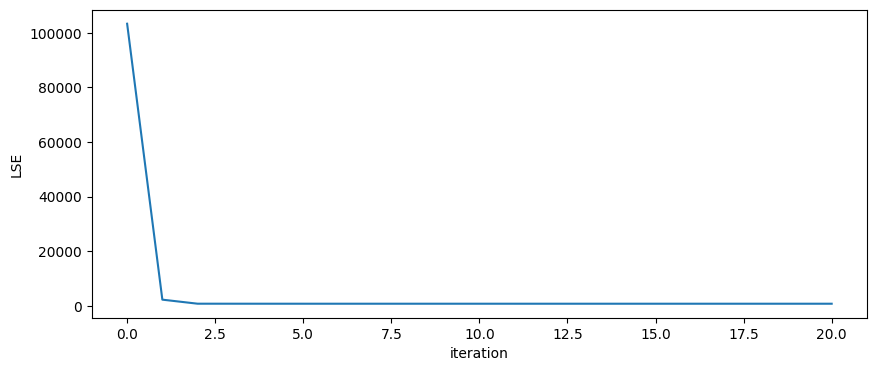

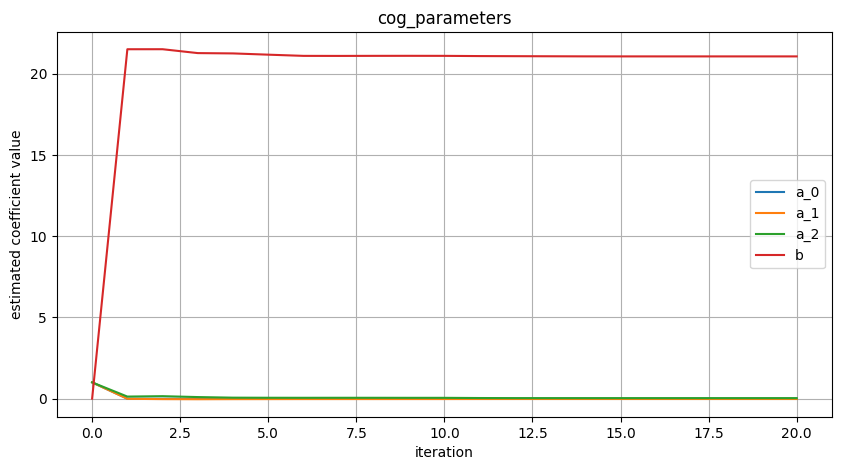

In [5]:
em_model_0 = EM(num_iterations=20, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.01)

path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac_lc001"
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K,
               save_path=path)
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

plot_lse(lse_history)
plot_cog_regression_history(em_model_0.cog_regression_history)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

100%|██████████| 20/20 [24:49<00:00, 74.48s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.16431976 0.14360002 0.14940134 0.2        0.2        0.2
 0.16534592 0.16286854 0.15807916 0.15390474]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac_lc01.npz
initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  1.3175898758309974
final theta:
f:  [0.164 0.144 0.149 0.2   0.2   0.2   0.165 0.163 0.158 0.154]
s:  [2.386 2.335 2.437 1.933 3.136 2.657 2.323 2.639 2.205 2.156]
s_k:  5.0

BETA SUMMARY:
beta initial:  [ 5.054  9.18   3.812  3.025 19.085 12.867  3.925  4.536  1.359 11.14 ]
beta final:  [19.227 20.    18.473 18.313 19.52  19.989 19.93  18.647 20.    18.802]


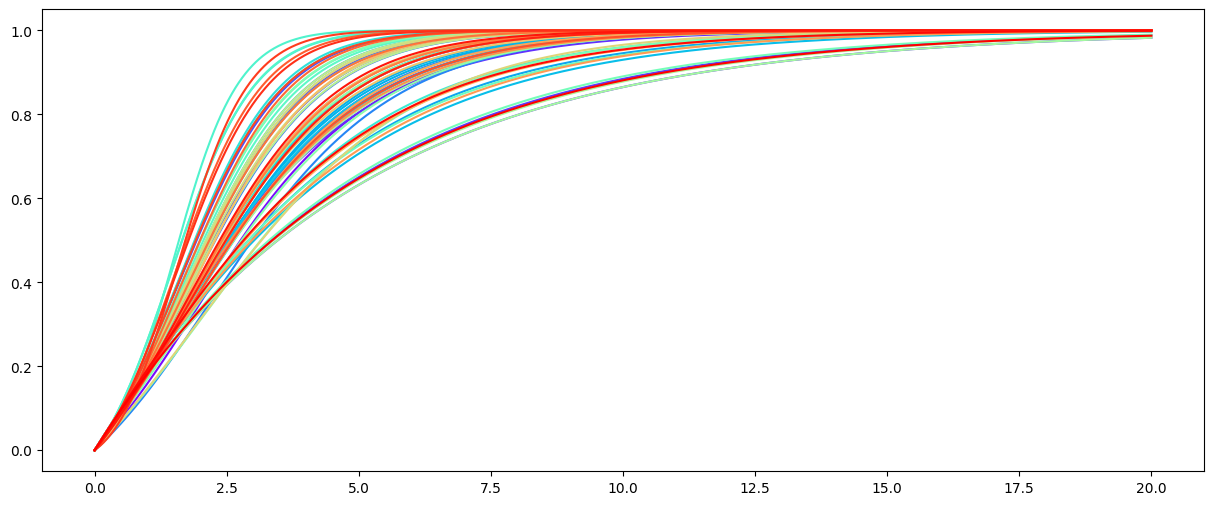

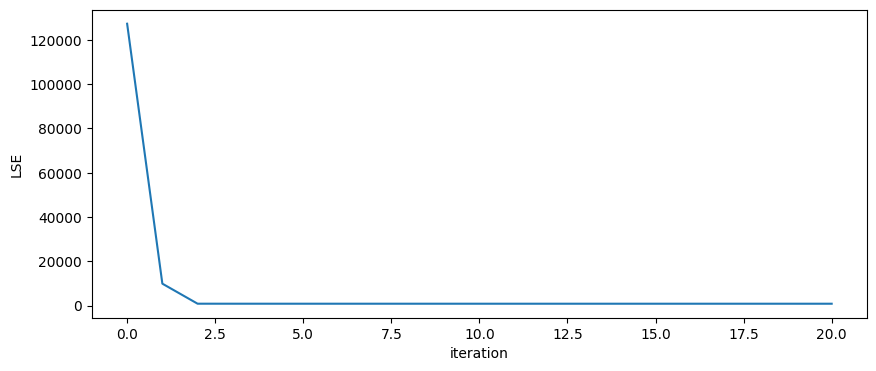

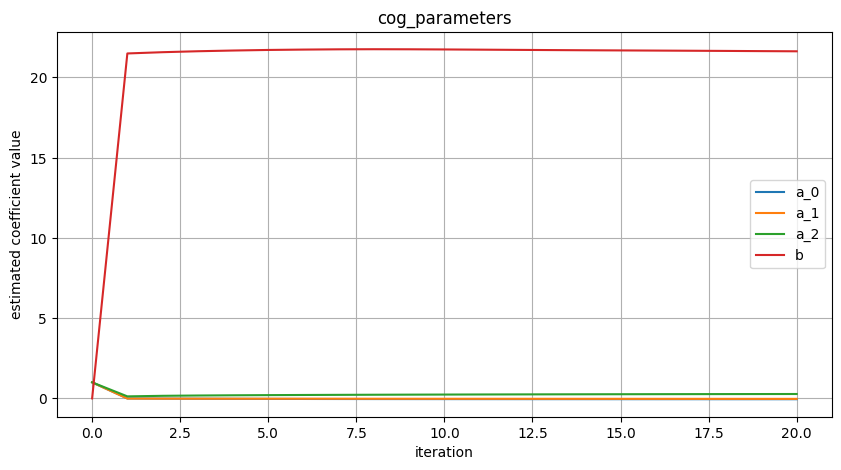

In [6]:
em_model_0 = EM(num_iterations=20, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.1)

path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac_lc01"
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K,
               save_path=path)
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

plot_lse(lse_history)
plot_cog_regression_history(em_model_0.cog_regression_history)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

100%|██████████| 20/20 [23:11<00:00, 69.57s/it] 



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.13766442 0.01688331 0.10441934 0.2        0.2        0.2
 0.11177647 0.10475794 0.09126674 0.09850385]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac_lc1.npz
initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  1.3175898758309974
final theta:
f:  [0.138 0.017 0.104 0.2   0.2   0.2   0.112 0.105 0.091 0.099]
s:  [2.386 2.342 2.437 1.934 3.137 2.658 2.323 2.639 2.205 2.156]
s_k:  5.0

BETA SUMMARY:
beta initial:  [ 5.054  9.18   3.812  3.025 19.085 12.867  3.925  4.536  1.359 11.14 ]
beta final:  [19.181 20.    18.419 18.202 19.562 19.957 19.936 18.613 20.    18.781]


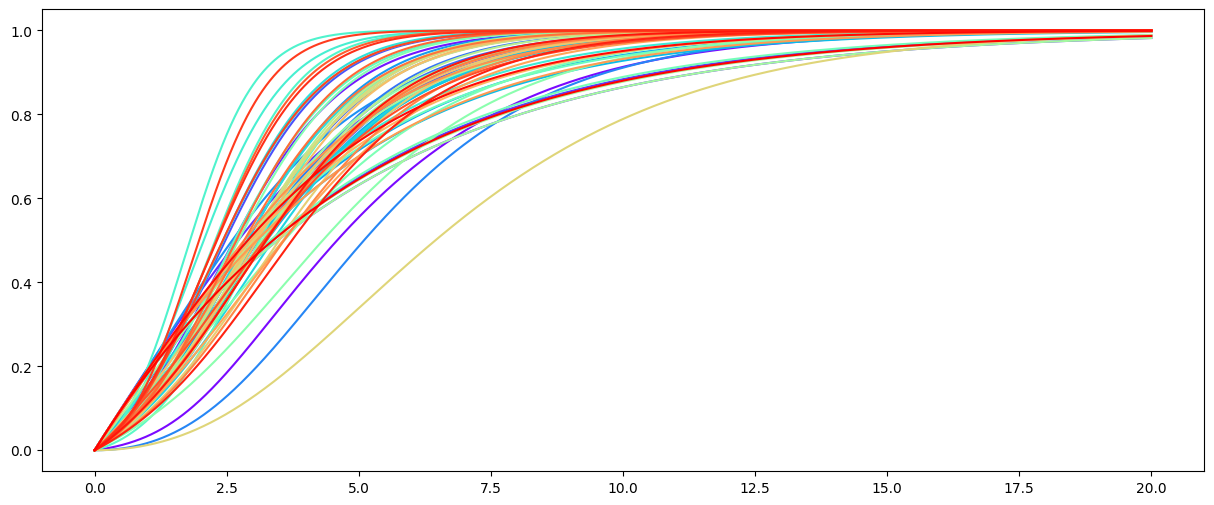

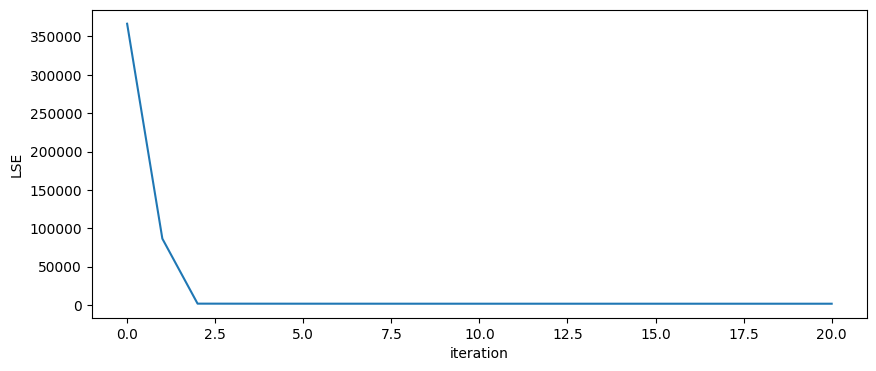

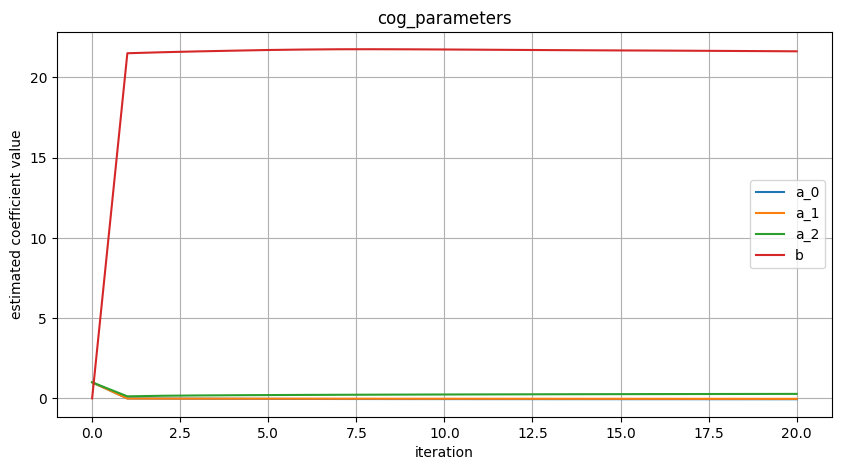

In [7]:
em_model_0 = EM(num_iterations=20, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=1.0)

path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi20_nojac_lc1"
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K,
               save_path=path)
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

plot_lse(lse_history)
plot_cog_regression_history(em_model_0.cog_regression_history)